In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import os
import gdal

# Trim ATL15 data to grounded ice sheet

# Entire ice sheet

In [2]:
src_path = "ATL15_AA_0311_01km_001_01.nc"
ds = xr.open_dataset(src_path, group='delta_h')
ds

<xarray.Dataset>
Dimensions:              (time: 12, x: 5521, y: 4521)
Coordinates:
  * x                    (x) float64 -2.72e+06 -2.719e+06 ... 2.799e+06 2.8e+06
  * y                    (y) float64 -2.2e+06 -2.199e+06 ... 2.319e+06 2.32e+06
  * time                 (time) datetime64[ns] 2018-10-01T22:30:00 ... 2021-07-02T09:00:00
Data variables:
    Polar_Stereographic  int8 ...
    cell_area            (y, x) float32 ...
    delta_h              (time, y, x) float32 ...
    delta_h_sigma        (time, y, x) float32 ...
    ice_mask             (y, x) float32 ...
    data_count           (time, y, x) float32 ...
    misfit_rms           (time, y, x) float32 ...
    misfit_scaled_rms    (time, y, x) float32 ...
Attributes:
    description:  delta_h group includes variables describing height differen...

(4521, 5521)


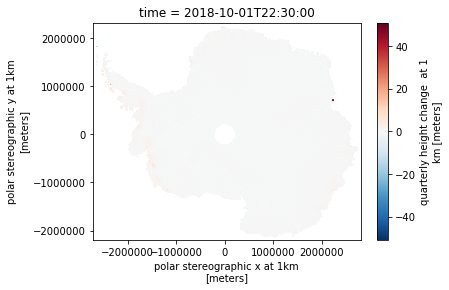

In [3]:
dh = ds['delta_h'][0,:,:]
dh.plot()
print(dh.shape)

# Perform trimming

In [4]:
%%bash
ml intel/17.4; ml proj/6.0.0; ml gdal/3.4.2; ml netcdf; 
gdal_translate -b 1 NETCDF:ATL15_AA_0311_01km_001_01.nc:/delta_h/delta_h out.tif
gdal_rasterize -i -burn -9999 Basins_Antarctica_v02.shp out.tif

Input file size is 5521, 4521
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
Warning 1: PROJ: proj_create_from_database: Cannot find proj.db
Warning 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 1: PROJ: proj_identify: Cannot find proj.db
ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db
ERROR 6: Cannot find coordinate operations from `PROJCRS["WGS_84_Antarctic_Polar_Stereographic",BASEGEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["Degree",0.0174532925199433]]],CONVERSION["unnamed",METHOD["Polar Stereographic (variant B)",ID["EPSG",9829]],PARAMETER["Latitude of standard parallel",-71,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8832]],PARAMETER["Longitude of origin",0,ANGLEUNIT["Degree",0.0174532925199433],ID["EPSG",8833]],PARAMETER["False easting",0,LENGTHUNIT["Meter",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["Meter",1],ID["EPSG",8807

(4521, 5521)


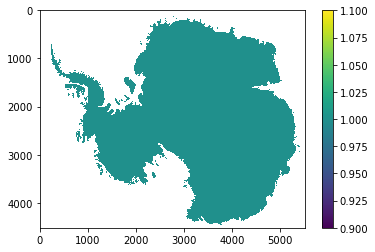

In [5]:
tif = gdal.Open("out.tif")
band = tif.GetRasterBand(1)
arr = band.ReadAsArray()
print(arr.shape)
arr[arr<-100] = np.nan
arr[arr>=-10] = 1
plt.imshow(arr)
plt.colorbar()
np.save("grounded_mask.npy", arr)

# Grounded ice sheet

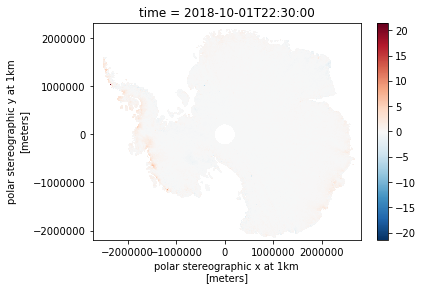

In [6]:
grounded_mask = np.load("grounded_mask.npy")
grounded_mask = xr.DataArray(data=np.flipud(grounded_mask), dims=["y", "x"], coords=[ds['y'],ds['x']])
dh = dh * grounded_mask
dh.plot()